# E9.나의 첫 번째 캐글 경진대회, 무작정 따라해보기

`02 FEB 2021`

-------------


### 필요한 라이브러리 import

In [2]:
import os
from os.path import join

# 분석 기본 도구
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
plt.style.use('bmh')

# 통계 분석 도구
from scipy import stats

# 시각화 도구
import folium
import geojson
from folium import plugins
from shapely.geometry import shape, Point, multipolygon
from shap import TreeExplainer, summary_plot

# 전처리 도구
from sklearn.preprocessing import LabelEncoder

# 학습 도구
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 검증 도구
#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import make_scorer
#from sklearn.metrics import mean_squared_error

# 경고문 무시(seaborn)
import warnings
warnings.filterwarnings('ignore')



# 1. Data 

- 문제 정의

이번 데이터의 목적은 집의 정보를 가지고 가격을 예측하는 회귀문제 입니다.

평가로는 RMSE를 사용합니다.


### ✓ 데이터 살펴보기
Baseline 노트북은 먼저 아래와 같이 데이터를 살펴보고 있네요. 각 변수들이 나타내는 의미를 읽어 보겠습니다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [149]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

# 테스트, 즉 submission 시 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [150]:
print('train shape : ',train.shape)
print('test shape : ',test.shape)

train shape :  (15035, 21)
test shape :  (6468, 20)


In [151]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- date 변수는 앞의 8자리 외 T부터는 처리가 필요해 보임.



In [37]:
for df in [train, test]:
    df['year'] = df['date'].apply(lambda x : x[0:4], range(len(df)))
    df['month'] = df['date'].apply(lambda x : x[4:6], range(len(df)))
    df['day'] = df['date'].apply(lambda x : x[6:8], range(len(df)))

In [14]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
year             0
month            0
day              0
dtype: int64

In [15]:
test.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
year             0
month            0
day              0
dtype: int64

train, test 데이터 모두 결측값 없이 깨끗함

# 2. Exploratory Data Analysis

<AxesSubplot:xlabel='price', ylabel='Density'>

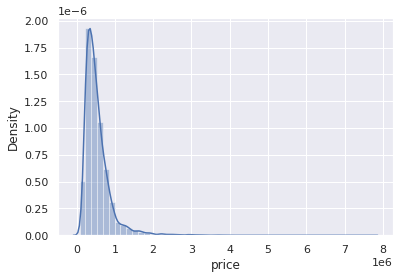

In [41]:
#histogram
sns.distplot(train['price'])

In [42]:
price_des = train.describe()['price']
price_des.astype('int')

count      15035
mean      540682
std       371524
min        78000
25%       322000
50%       450000
75%       645000
max      7700000
Name: price, dtype: int64

price의 경우 왼쪽으로 분포가 많이 치우친 것을 알 수 있었다. = price 데이터의 값이 한쪽으로 많이 치우쳐져있다.

분산이 크기 때문에 정규화를 통해서 price가 정규분포를 가질 수 있도록 하겠습니다.  


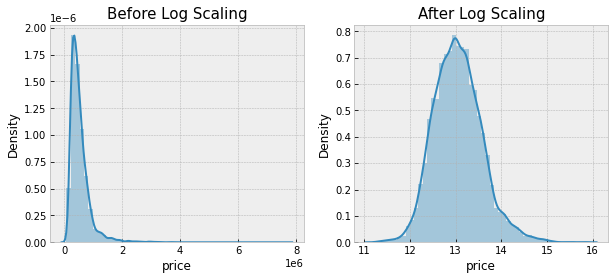

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

sns.distplot(train['price'], ax=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
sns.distplot(np.log1p(train['price']), ax=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

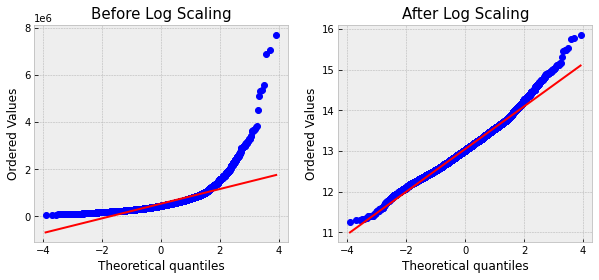

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

reg = stats.probplot(train['price'], plot=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
reg = stats.probplot(np.log1p(train['price']), plot=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

스피어만 순위 상관관계를 기준으로 목적변수와 상관도가 높은 상위 10개의 반응변수 시각화

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

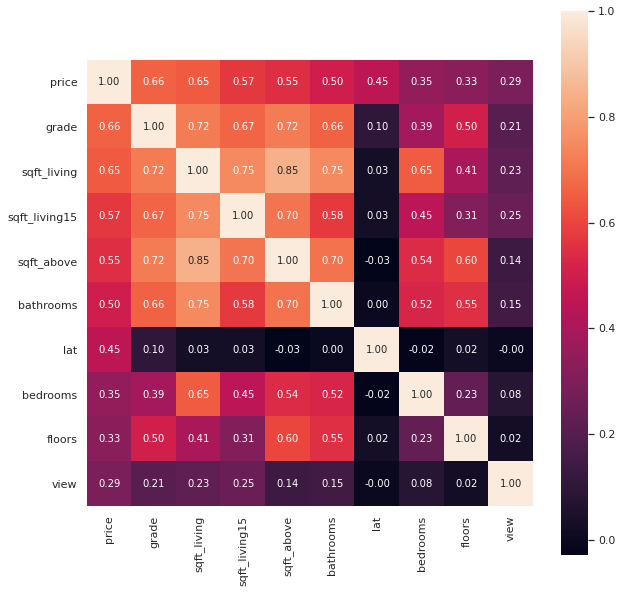

In [34]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 10} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

## 3. Map visualization

해커톤 이후로 지도를 활용해 시각화 하는것에 빠져버렸다. 이번에도 타겟인 price데이터의 값을 가지고 map visuallization을 해보겠습니다. 


In [24]:
map_count = folium.Map(location=[train['lat'].mean(), train['long'].mean()],
                      min_zoom=8,
                      #max_zoom=11,
                      width=960,  # map size scaling
                      height=540)

lat_long_data = train[['lat', 'long']].values.tolist()
h_cluster = folium.plugins.FastMarkerCluster(lat_long_data).add_to(map_count)

map_count

In [25]:
zipcode_data = train.loc[:, ['price', 'lat', 'long', 'zipcode']]
zipcode_data['coord'] = [(round(x,6), round(y,6)) for x, y in zip(train['long'], train['lat'])]
del zipcode_data['lat']
del zipcode_data['long']

print(zipcode_data.shape)
zipcode_data.head()

(15035, 3)


,price,zipcode,coord
0,221900.0,98178,"(-122.257, 47.5112)"
1,180000.0,98028,"(-122.233, 47.7379)"
2,510000.0,98074,"(-122.045, 47.6168)"
3,257500.0,98003,"(-122.327, 47.3097)"
4,291850.0,98198,"(-122.315, 47.4095)"


In [126]:
geo_zipcode = geojson.load(open('/home/ssac17/Downloads/zipcode_king_county.geojson', encoding='utf-8'))

In [127]:
def zipcode(coord):
    point = Point(coord)
    for feature in geo_zipcode['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['ZCTA5CE10']
    return 'Outlier'

In [131]:
# 생성
# zipcode_data['zipcode'] = zipcode_data.coord.apply(zipcode) #경고: 2~3분 걸립니다.
# zipcode_data.head()

# 저장
# zipcode_data.to_csv('/home/ssac17/Downloads/zipcode_data.csv', index=None, encoding='utf-8')

# 불러오기
zipcode_data = pd.read_csv('/home/ssac17/Downloads/zipcode_data.csv', index_col=None, header=0, encoding='utf-8')

print(zipcode_data.shape)
zipcode_data.head()


(15035, 3)


,price,zipcode,coord
0,221900.0,98178,"(-122.257, 47.5112)"
1,180000.0,98028,"(-122.233, 47.7379)"
2,510000.0,98074,"(-122.045, 47.6168)"
3,257500.0,98003,"(-122.327, 47.3097)"
4,291850.0,98198,"(-122.315, 47.4095)"


In [132]:
zipcode = pd.pivot_table(zipcode_data, index=['zipcode'])

print(zipcode.shape)
zipcode.head()

(70, 1)


,price
zipcode,
98001,2.800475e+05
98002,2.355189e+05
98003,2.869325e+05
98004,1.395841e+06
98005,7.963691e+05


In [133]:
map_price = folium.Map(location=[train['lat'].mean(), train['long'].mean()],
                       min_zoom=8, # 고정
                       max_zoom=10,
                       tiles='OpenStreetMap',
                       width=960,
                       height=540,
                      )

folium.Choropleth(
    geo_data=geo_zipcode, 
    data=zipcode['price'],
    columns=[zipcode.index, zipcode['price']],
    fill_color='Reds',
    fill_opacity=0.5,
    line_opacity=0.8,
    key_on='feature.properties.ZCTA5CE10',
).add_to(map_price)

map_price


- 1. Feature Engineering
좌표와 가격만을 가지고 clustering하는 것 보다 zipcode를 이용한 평방 대비 가격(price per footage)을 확인해보는 것이 좋다고 판단하여 여러 커널들을 참고해 보았습니다. 


연도를 쓰지 않고 2014년 5월부터 2015년 5월까지의 시간을 열 세달(1~13)로 쪼개어 재정렬  → 
건축 관련 수치 추가

floor_area_ratio(sqft_living / sqft_lot) 추가  →  성능 상승
building_coverage(sqft_above / (floor * sqft_lot)) 추가  →  효과 없었음
그 외 여러가지 시도
지하실 유무, 다락방 유무, 재건축 유무 등에 대한 feature를 추가할 수도 있으나 효과 없었음

feature의 개수가 많아져서 model complexity가 증가하면 overfitting이 강력해지기 때문으로 추측
방 관련 feature 추가

방 총 개수 추가  →  효과 없었음
sqft_lot15 제거  →  상황마다 다른 걸로 결론

how_old: 건물이 건축되고 리모델링 된 후, 팔리기까지 걸린 시간

yr_renovated 제거

- 2. Log Scaling
평방 관련 수치에 대해 log scaling

- 3. Label Encoding
zipcode에 Label Encoding
yr_built = yr_built - 1900 적용

In [152]:
le = LabelEncoder()
le.fit(train['zipcode'])
le.fit(test['zipcode'])

train['zipcode'] = le.transform(train['zipcode'])
test['zipcode'] = le.transform(test['zipcode'])

In [153]:

train['price_per_land_area'] = train['price'] / (train['sqft_living'])
price_per_ft = train.groupby(['zipcode'])['price_per_land_area'].agg({'mean', 'std', 'count'}).reset_index()

train = pd.merge(train, price_per_ft, how='left', on='zipcode')
test = pd.merge(test, price_per_ft, how='left', on='zipcode')

del train['price_per_land_area']

In [154]:
X_train = train.drop(['id', 'price'], axis=1)
y_train = train['price']
y_train = np.log1p(y_train)
X_test = test.drop(['id'], axis=1)

In [155]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'std', 'mean', 'count'],
      dtype='object')

In [156]:
# Adding features
for df in [X_train, X_test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400)
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1)
    del df['date']
    del df['yr_renovated']
    df['yr_built'] = df['yr_built'] - 1900
    df['sqft_floor'] = df['sqft_above'] / df['floors']
    df['floor_area_ratio'] = df['sqft_living'] / df['sqft_lot']
    del df['sqft_lot15']

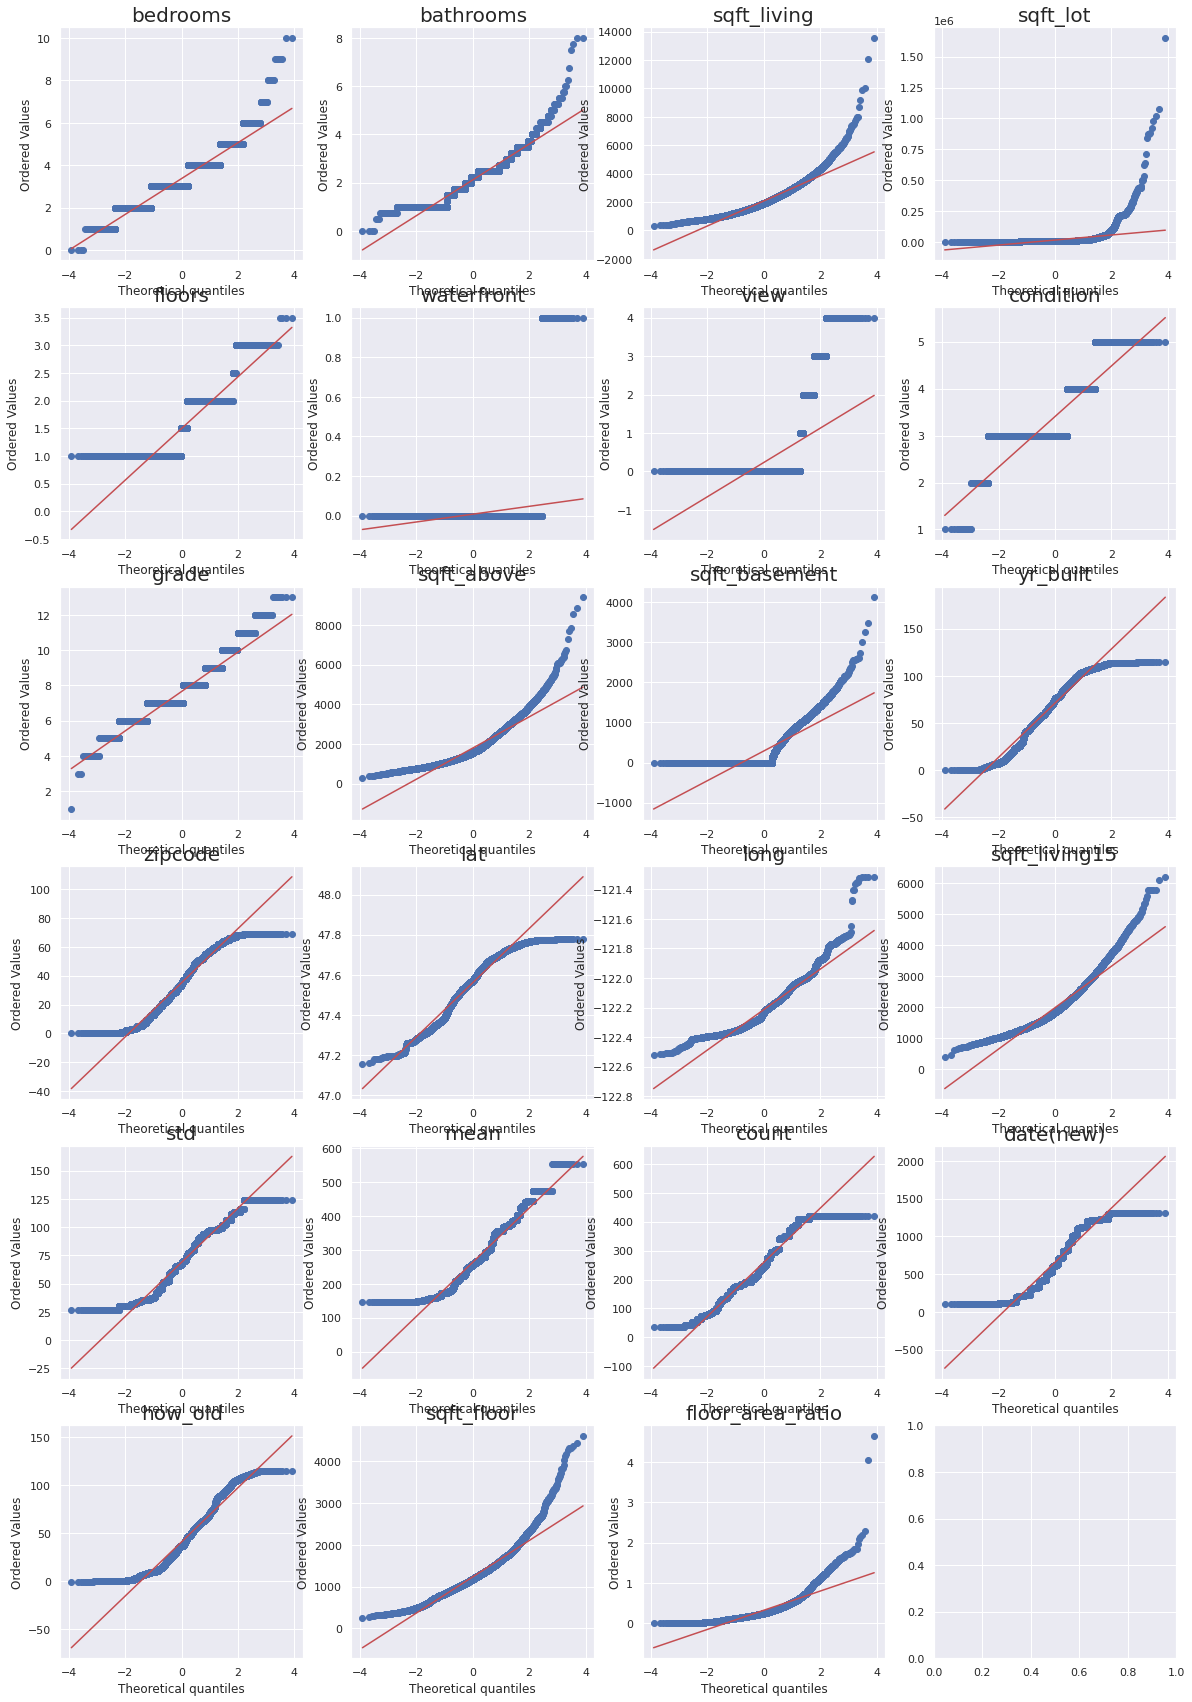

In [157]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

In [158]:

# Log Scaling
log_features = ['bedrooms', 'bathrooms', 'sqft_lot', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_floor', 'mean', 'floor_area_ratio', 'floor_area_ratio']
for feature in log_features:
    for df in [X_train, X_test]:
        df[feature] = np.log1p(df[feature])

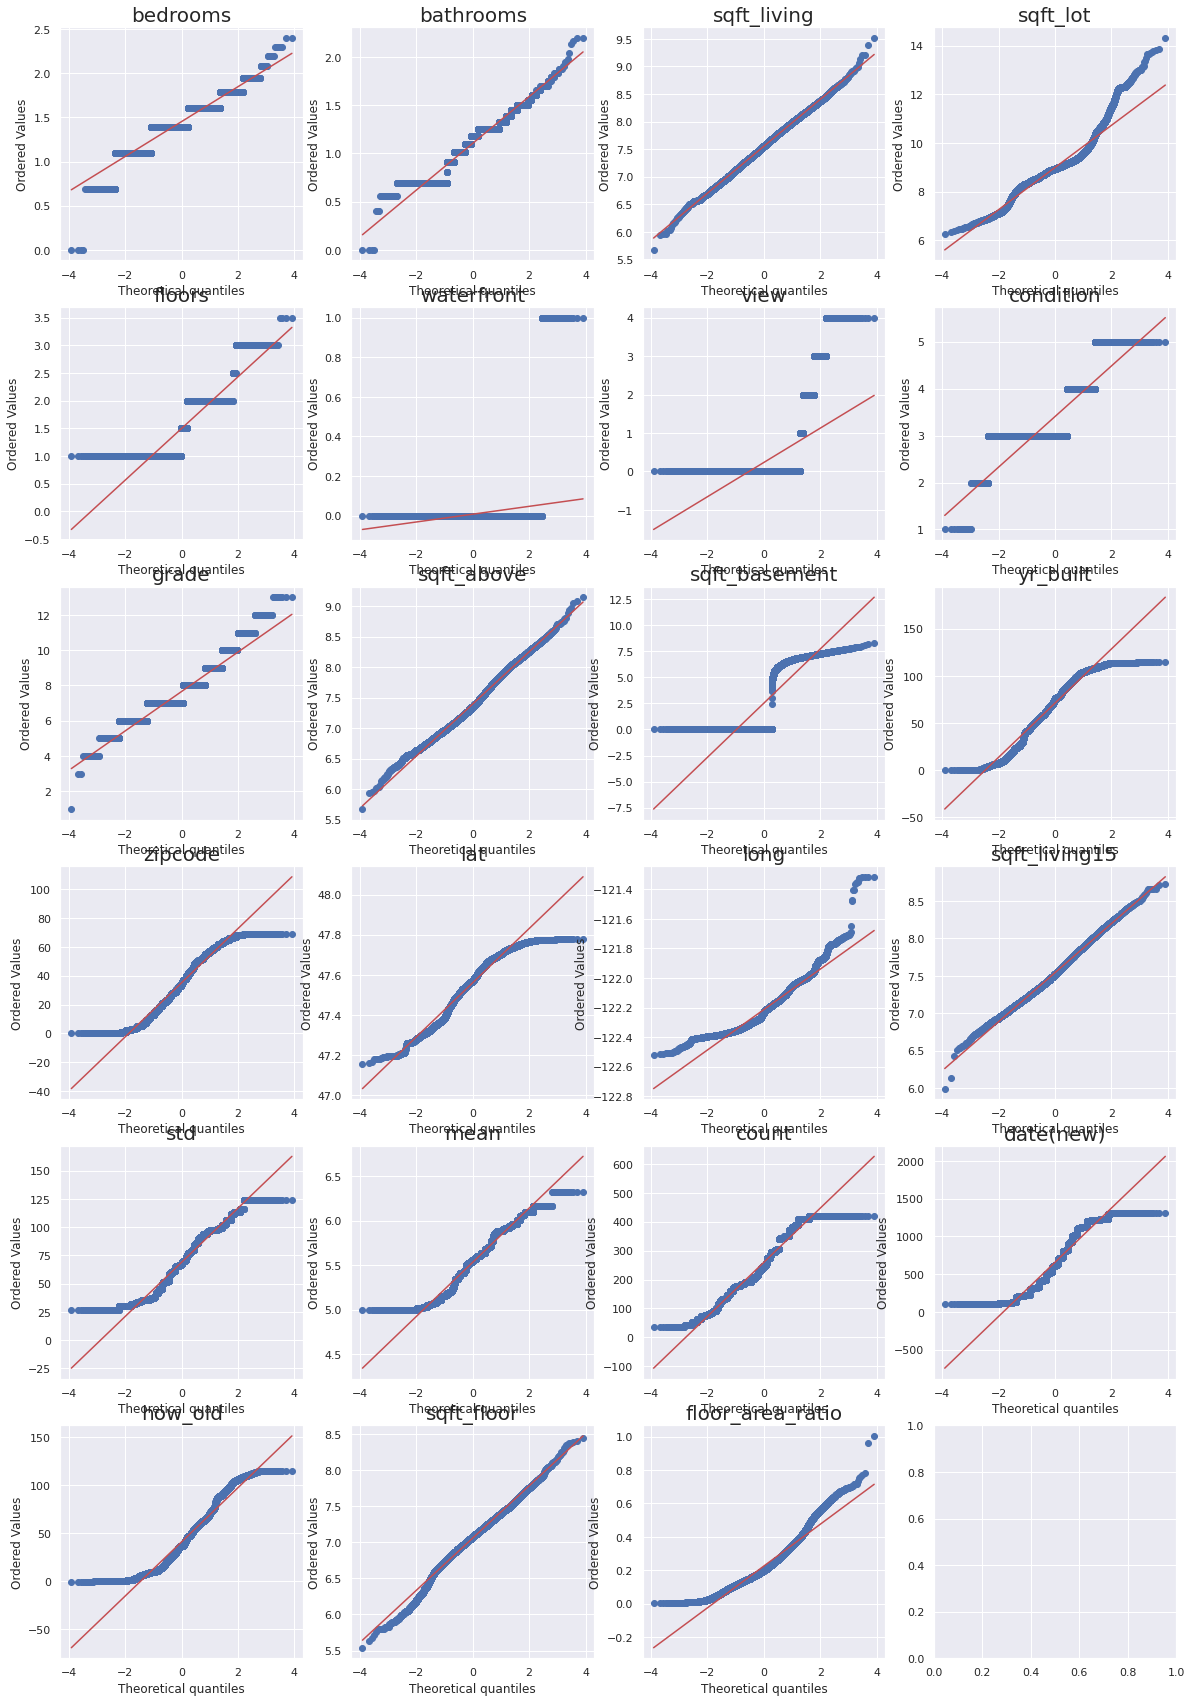

In [159]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

# 4. Modeling


## 그리드 서치 함수


In [179]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5):
    #1. GridSearchCV 모델로 `model`을 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                            scoring='neg_mean_squared_error', \
                            cv=5, verbose=1, n_jobs=5)
    
    #2. 모델을 fitting 
    grid_model.fit(X_train, y_train)
    
    #3. params, score에 각 조합에 대한 결과를 저장 
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    #4. 데이터 프레임을 생성하고, 
    results = pd.DataFrame(params)
    results['score'] = score
    
    #5. RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results['RMSLE'].sort_values()
    
    return results

In [165]:
random_state = 2021
param_grid = {
    'n_estimators': [100, 1000],
    'learning_rate' : [0.05, 0.1],
    'max_depth': [10, 100], 
}

    
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    9.4s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.05,10,100,-0.028220,0.167988
1,0.05,10,1000,-0.025732,0.160413
2,0.05,100,100,-0.028151,0.167784
3,0.05,100,1000,-0.025837,0.160739
4,0.10,10,100,-0.026758,0.163579
5,0.10,10,1000,-0.026843,0.163837
6,0.10,100,100,-0.026786,0.163664
7,0.10,100,1000,-0.026874,0.163934


In [175]:
random_state = 2021
param_grid = {
    'n_estimators': [100, 1000],
    'learning_rate' : [0.05, 0.1],
    'max_depth': [10, 100], 
}

    
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    5.3s finished


,learning_rate,n_estimators,score,RMSLE
0,0.05,100,-0.028151,0.167784
1,0.05,1000,-0.025837,0.160739
2,0.10,100,-0.026786,0.163664
3,0.10,1000,-0.026874,0.163934


In [183]:
param_grid = {
    'n_estimators': [100, 1000],
    'learning_rate' : [0.05, 0.1],
    #'max_depth': [1, 10], 
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:  3.2min finished


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.001,5,100,-129.166816,11.365158
1,0.001,5,1000,-21.405910,4.626652
2,0.001,10,100,-129.166816,11.365158
3,0.001,10,1000,-21.405910,4.626652
4,0.010,5,100,-21.213576,4.605820
5,0.010,5,1000,-0.027586,0.166089
6,0.010,10,100,-21.213576,4.605820
7,0.010,10,1000,-0.026072,0.161469


In [201]:
model = LGBMRegressor(learning_rate=0.05, n_estimators=700, random_state=random_state)


## 캐글 제출을 위한 함수


In [202]:
def save_submission(model, X_train, y_train, X_test, model_name, rmsle=None):
    
    #1. 모델 훈련
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    prediction = np.expm1(prediction)
    
    #2. submission 데이터프레임
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    print(submission.head())

    #3. 결과 저장
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [203]:
save_submission(model, X_train, y_train, X_test, 'lgbm' ,rmsle='0.162')


      id         price
0  15035  5.338753e+05
1  15036  4.966907e+05
2  15037  1.352827e+06
3  15038  3.091511e+05
4  15039  3.309585e+05
/home/ssac17/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.162.csv saved!


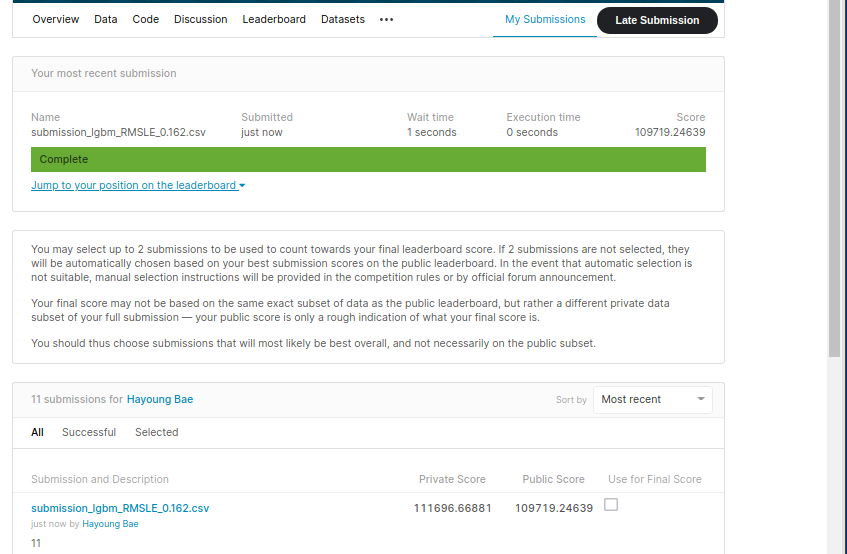

## 회고

해커톤을 진행하기에 앞서 미리 조원들과 예비로 진행해보았던 캐글 노드였다. 전반적으로 전처리, 데이터 시각화 등 어떻게 베이스라인을 잡고 나가야하는지 알 수 있었다. 

사실 잘 짜여진 여러 노드들을 참고 했기 때문에 처음엔 이게 과연 의미가 있는걸까 라는 생각이 많이 들었다. 그런데 다양한 커널들을 같이 뜯어보면서 막히는 부분은 조원들과 함께 이야기해보면서 어떤 변수를 중심으로 잡고 분석해 볼지 토의하는 과정이 재미있었다. 

다만 더 많은 라이브러리들을 가지고 분석할 수 있는 스킬을 가지면 더 좋을 것 같아서 앞으로 시간이 날때 마다 좋은 커널을 참고하면서 따라해보려고 한다. folium과 geopandas라는 라이브러리를 알게 되었는데 확실히 데이터가 Map과 연관지어서 찾아 볼 수 있다면 이 라이브러리를 이용해서 어떻게 feature Engineering의 방향성을 잡아가는게 훨씬 직관적으로도 이해가 잘 갔다. 해커톤의 주제도 러시아 지역을 통해서 시각화해서 데이터를 전처리 할 방향을 논의했을 때도 팀원 분들이 진행 방향을 잡는데 도움을 주었던것 같다. 


특히 가장 좋은 파라미터를 찾는 과정이 쉽지 않았는데 시간을 더 투자 했으면 좋은 결과 값을 얻을 수 있었을것 같다.
어쩌다 보니 해커톤 팀원분과 같이 해커톤 전에 미팅을 가지면서 이번 노드를 진행했었는데 내가 아무리 하이퍼파라미터를 조정해보아도 떨어지지 않던 점수가 팀원분이 찾아내신 좋은 파라미터값의 조언을 얻어서 진행하니 바로 110000대에서 벗어날 수 있었다.. 


하지만 다시한번 부족함이 참 많다고 느꼈고 앞으로 계속해서 더 발전 시켜야겠다. 



## 어려웠던점

- 데이터 분석에서 가장 중요한 것은 EDA 부분이라고 많이 느꼈다. 어떤 값들이 중요한지, 필요 없거나 이상치들은 잘 걸러낼수 있어야 그것이 결과에 생각보다 큰 영향을 끼친다는 것을 알 수 있었다. 

### 시각화 참고


https://github.com/harlfoxem/House_Price_Prediction/blob/master/House_Price_Prediction_Part1.ipynb

https://www.kaggle.com/fulrose/eda-with-map-visualization/data
